In [31]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import networkx as nx
import itertools
import matplotlib.pyplot as plt
from adjustText import adjust_text

In [20]:
df = pd.read_csv(r'../data/dataframes/clean_labeled.csv')

def get_summary(df):
    summary_df = pd.DataFrame({
        'Non-NA Count': df.notna().sum(),
        'NA Count': df.isna().sum(),
        'Unique Values': df.nunique(dropna=False),  # Includes NaN in the count of unique values
        'Data Type': df.dtypes
    })
    return summary_df

print(get_summary(df))
print(df.head())

                     Non-NA Count  NA Count  Unique Values Data Type
SongID                       1815         0            332     int64
start_time                   1815         0            884   float64
end_time                     1815         0           1202   float64
label                        1815         0              2    object
TrackName                    1815         0            331    object
Artists                      1815         0            275    object
Genre                        1608       207             62    object
FilePath                     1815         0            332    object
sp_danceability              1751        64            206   float64
sp_energy                    1751        64            217   float64
sp_key                       1751        64             13   float64
sp_loudness                  1751        64            312   float64
sp_speechiness               1751        64            259   float64
sp_acousticness              1751 

In [21]:
# Convert the comma-separated string of genres to a list of genres
df['sp_genre'] = df['sp_genre'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])

In [3]:
# Flatten the list of genres
all_genres = [genre for sublist in df['sp_genre'] if isinstance(sublist, list) for genre in sublist]

# Count the occurrences of each genre
genre_counts = pd.Series(all_genres).value_counts()

# Filter out genres with less than 5 occurrences
popular_genres = genre_counts[genre_counts >= 5]

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(popular_genres)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Genre Word Cloud')
plt.show()

NameError: name 'df' is not defined

In [4]:
# Create a dictionary to store the number of unique artists associated with each genre
genre_artist_counts = {}

# Iterate over the unique genres in genre_counts
for genre in genre_counts.index:
    # Initialize an empty set to store unique artists for each genre
    unique_artists = set()
    # Iterate over rows where the genre appears in sp_genre
    for idx, row in df[df['sp_genre'].apply(lambda x: genre in x)].iterrows():
        # Split artists by '/' and add to the set
        artists = row['Artists'].split('/')
        unique_artists.update(artists)
    # Store the number of unique artists for the genre
    genre_artist_counts[genre] = len(unique_artists)

# Sort the dictionary by the number of unique artists in descending order
sorted_genre_artist_counts = dict(sorted(genre_artist_counts.items(), key=lambda item: item[1], reverse=True))

# Convert the sorted_genre_artist_counts dictionary to lists for plotting
top_n = 20
genres = list(sorted_genre_artist_counts.keys())[:top_n]
unique_artists_counts = list(sorted_genre_artist_counts.values())[:top_n]

# Create the bar plot
plt.figure(figsize=(10, 8))
plt.barh(genres, unique_artists_counts, color='skyblue')
plt.xlabel('Number of Unique Artists')
plt.ylabel('Genre')
plt.title('Top 20 Genres by Unique Artist Count')
plt.gca().invert_yaxis()  # Invert y-axis to have the genre with the most artists on top
plt.show()

NameError: name 'genre_counts' is not defined

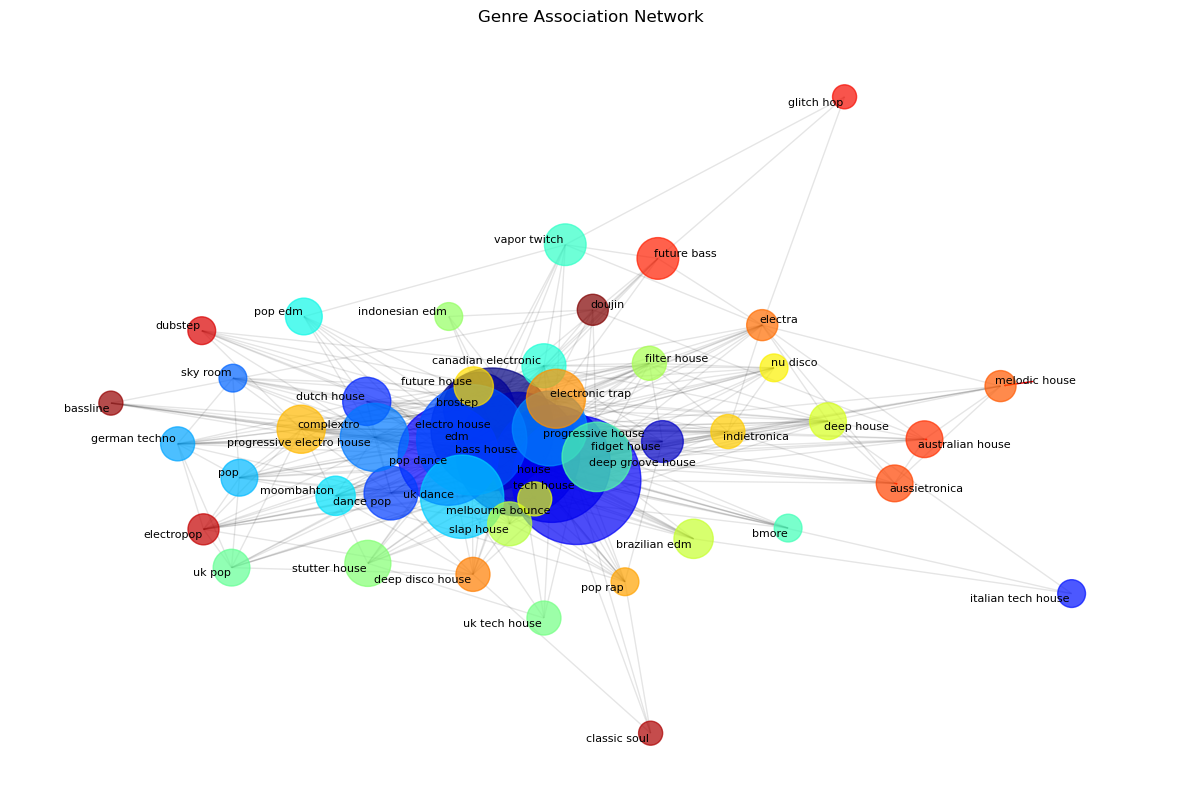

In [33]:
# Create an empty graph
G = nx.Graph()

# Get the top 50 genres based on the number of unique artists associated with each genre
top_genres = list(sorted_genre_artist_counts.keys())[:50]

# Create a dictionary to store the number of unique artists associated with each genre
genre_artist_counts = {}

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    genres = row['sp_genre']
    artists = row['Artists'].split('/')
    for genre in genres:
        if genre in top_genres:
            genre_artist_counts.setdefault(genre, set()).update(artists)

# Add nodes and edges to the graph
for genre, artists in genre_artist_counts.items():
    G.add_node(genre, size=len(artists))

for genres in df['sp_genre']:
    for genre1 in genres:
        if genre1 in top_genres:
            for genre2 in genres:
                if genre2 in top_genres and genre1 != genre2:
                    if G.has_edge(genre1, genre2):
                        G[genre1][genre2]['weight'] += 1
                    else:
                        G.add_edge(genre1, genre2, weight=1)

# Get the node sizes
node_sizes = [G.nodes[n]['size'] * 100 for n in G.nodes]

# Draw the network
plt.figure(figsize=(15, 10))  # Increased figure size for better clarity

# Optimize the layout
pos = nx.spring_layout(G, k=0.3, iterations=50)

# Draw edges with thickness based on edge weights and reduced opacity
nx.draw_networkx_edges(G, pos, alpha=0.1)

# Draw nodes with sizes based on the number of unique artists associated and customize appearance
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=range(len(G)), cmap=plt.cm.jet, alpha=0.7)

# Prepare labels for adjust_text
labels = {n: n for n in G.nodes()}  # Dictionary comprehension to create a label for each node
texts = [plt.text(pos[n][0], pos[n][1], labels[n], ha='center', va='center', fontsize=8) for n in G.nodes()]

# Use adjust_text to prevent overlap, you might need to adjust the parameters
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

# Remove axes
plt.axis('off')
plt.title('Genre Association Network')
plt.show()